In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import randint
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA

In [18]:
model_df = pd.read_csv('model_df.csv', index_col=0)
model_df.head()

,net_bikes_percentage,start_date,day_of_week,month,station_name,st_dist_to_center,district,female,male,unk_gender,customer,subscriber,gen_z,millennial,gen_x,baby_boomer,silent_gen,unk_generation
0,0.000000,2018-01-01,Monday,January,Ames St at Main St,1.655844,Cambridge,0.201768,0.573416,0.224815,0.067256,0.932744,0.083780,0.525076,0.146108,0.051022,0.001087,0.192927
1,15.789474,2018-01-02,Tuesday,January,Ames St at Main St,1.655844,Cambridge,0.206623,0.584041,0.209336,0.063307,0.936693,0.085362,0.529798,0.148098,0.055456,0.001285,0.180001
2,-15.789474,2018-01-03,Wednesday,January,Ames St at Main St,1.655844,Cambridge,0.204221,0.595088,0.200691,0.071702,0.928298,0.086851,0.545227,0.144286,0.054273,0.001544,0.167819
3,0.000000,2018-01-06,Saturday,January,Ames St at Main St,1.655844,Cambridge,0.181425,0.528949,0.289625,0.200943,0.799057,0.096411,0.554755,0.136495,0.017422,0.001834,0.193084
4,5.263158,2018-01-07,Sunday,January,Ames St at Main St,1.655844,Cambridge,0.176317,0.535177,0.288506,0.181384,0.818616,0.099016,0.546902,0.127389,0.019977,0.000000,0.206717


In [3]:
y = model_df['net_bikes_percentage']
features = ['day_of_week', 'month', 'station_name', 'st_dist_to_center', 'district', 'female', 'male', 'unk_gender', 'customer', 'subscriber', 'gen_z', 'millennial', 'gen_x', 'baby_boomer', 'silent_gen', 'unk_generation']
X = model_df[features]

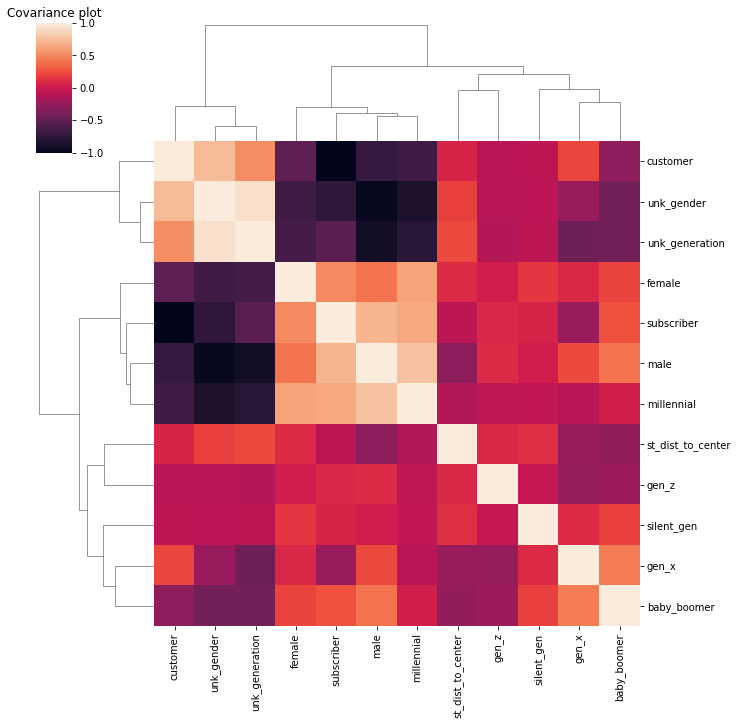

In [ ]:
sns.clustermap(X.corr())
plt.title('Covariance plot')
plt.show()

In [ ]:
#for categorical variables
X_onehot = pd.get_dummies(X)

In [ ]:
X_onehot.columns

Index(['st_dist_to_center', 'female', 'male', 'unk_gender', 'customer',
       'subscriber', 'gen_z', 'millennial', 'gen_x', 'baby_boomer',
       ...
       'station_name_Wilson Square', 'district_Arlington', 'district_Boston',
       'district_Brookline', 'district_Cambridge', 'district_Everett',
       'district_Newton', 'district_Revere', 'district_Somerville',
       'district_Watertown'],
      dtype='object', length=348)

In [ ]:
X_onehot.shape

(216869, 348)

In [ ]:
#scale
scaler = StandardScaler()
X_onehot['st_dist_to_center'] = scaler.fit_transform(X_onehot[['st_dist_to_center']])

In [ ]:
X_onehot.head()

,st_dist_to_center,female,male,unk_gender,customer,subscriber,gen_z,millennial,gen_x,baby_boomer,silent_gen,unk_generation,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September,station_name_175 N Harvard St,station_name_191 Beacon St,station_name_30 Dane St,station_name_359 Broadway - Broadway at Fayette Street,station_name_645 Summer St,station_name_699 Mt Auburn St,station_name_7 Acre Park,station_name_700 Commonwealth Ave.,station_name_700 Huron Ave,...,station_name_Tremont St at Northampton St,station_name_Tremont St at W. Dedham St,station_name_Tremont St at West St,station_name_Troy Boston,station_name_Union Square - Brighton Ave at Cambridge St,station_name_Union Square - Somerville,station_name_University Park,station_name_University of Massachusetts Boston - Campus Center,station_name_Vassal Lane at Tobin/VLUS,station_name_Verizon Innovation Hub 10 Ware Street,station_name_W Broadway at D St,station_name_W Broadway at Dorchester St,station_name_Warren St at Chelsea St,station_name_Wasgatt Playground,station_name_Washington St at Brock St,station_name_Washington St at Crafts St,station_name_Washington St at Lenox St,station_name_Washington St at Melnea Cass Blvd,station_name_Washington St at Myrtle St,station_name_Washington St at Rutland St,station_name_Washington St at Talbot Ave,station_name_Washington St at Waltham St,station_name_Watermark Seaport - Boston Wharf Rd at Seaport Blvd,station_name_Watertown Sq,station_name_Wentworth Institute of Technology - Huntington Ave at Vancouver St,station_name_West End Park,station_name_West Newton,station_name_West Newton Armory,station_name_Whittier St Health Center,station_name_Williams St at Washington St,station_name_Wilson Square,district_Arlington,district_Boston,district_Brookline,district_Cambridge,district_Everett,district_Newton,district_Revere,district_Somerville,district_Watertown
0,-0.595475,0.201768,0.573416,0.224815,0.067256,0.932744,0.083780,0.525076,0.146108,0.051022,0.001087,0.192927,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,-0.595475,0.206623,0.584041,0.209336,0.063307,0.936693,0.085362,0.529798,0.148098,0.055456,0.001285,0.180001,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,-0.595475,0.204221,0.595088,0.200691,0.071702,0.928298,0.086851,0.545227,0.144286,0.054273,0.001544,0.167819,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,-0.595475,0.181425,0.528949,0.289625,0.200943,0.799057,0.096411,0.554755,0.136495,0.017422,0.001834,0.193084,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,-0.595475,0.176317,0.535177,0.288506,0.181384,0.818616,0.099016,0.546902,0.127389,0.019977,0.000000,0.206717,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


Text(0, 0.5, 'Proportion of Variance Explained')

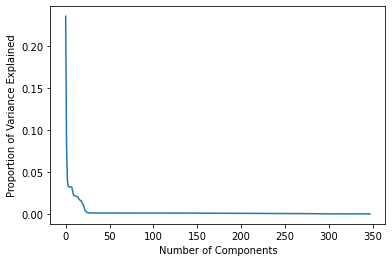

In [ ]:
pca = PCA()
pca.fit(X_onehot)

variance = pca.explained_variance_ratio_

plt.plot(range(len(variance)), variance)
plt.xlabel("Number of Components")
plt.ylabel("Proportion of Variance Explained")

In [ ]:
names = X_onehot.columns.values

In [ ]:
pca_df = pd.DataFrame({'col_name':names, 'exp_var':pca.explained_variance_ratio_})

In [ ]:
pca_df.sort_values('exp_var', ascending=False).head(10)

,col_name,exp_var
0,st_dist_to_center,0.235549
1,female,0.082844
2,male,0.039365
3,unk_gender,0.032442
4,customer,0.032259
5,subscriber,0.032207
6,gen_z,0.032082
7,millennial,0.031772
8,gen_x,0.027141
9,baby_boomer,0.022036


In [ ]:
pca = PCA(.95)
trns_X = pca.fit_transform(X_onehot)

In [ ]:
trns_X.shape

(216869, 195)

In [ ]:
#split data 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(trns_X, y, test_size = .2, random_state = 42)

In [ ]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
linreg.score(X_test, y_test)

0.08284165806668166

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mae

20.669275000521004

In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

33.187598082476896

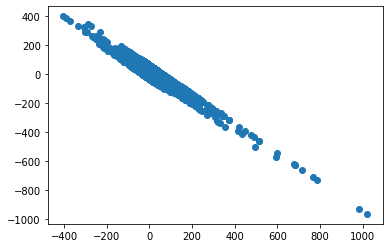

In [ ]:
#plot of residuals
plt.scatter(y_test, y_pred-y_test)

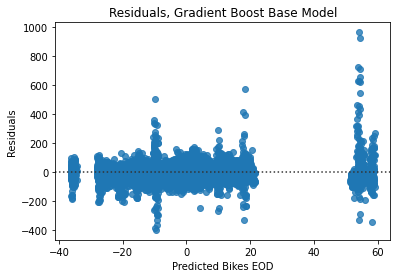

In [ ]:
sns.residplot(x = y_pred, y = y_test - y_pred)
plt.title('Residuals, Gradient Boost Base Model', size = 12)
plt.ylabel('Residuals', size = 10)
plt.xlabel('Predicted Bikes EOD', size = 10)
plt.show()

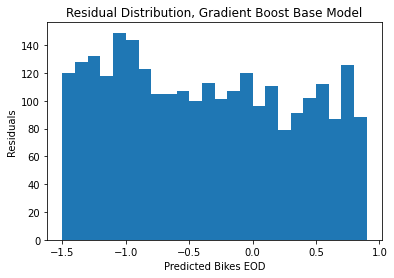

In [ ]:
plt.hist(y_test - y_pred, bins = np.arange(-1.5, 1, 0.1))
plt.title('Residual Distribution, Gradient Boost Base Model', size = 12)
plt.ylabel('Residuals', size = 10)
plt.xlabel('Predicted Bikes EOD', size = 10)
plt.show()

In [ ]:
# Lasso
lasso = Lasso(alpha=.1, normalize = True)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
lasso.score(X_test, y_test)

-2.341734718136479e-06

In [ ]:
from sklearn.linear_model import Lasso

alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

for alpha in alphas:
    
    lasso = Lasso(alpha = alpha, fit_intercept = True, random_state = 1)
    lasso.fit(X_train, y_train)
    new_train_error = np.sqrt(mean_squared_error(y_train, lasso.predict(X_train)))
    new_validation_error = np.sqrt(mean_squared_error(y_pred, lasso.predict(X_test)))
    print('alpha: {:7} | train error: {:5} | val error: {:6}'.
          format(alpha,
                 round(new_train_error,10),
                 round(new_validation_error,10)))

alpha:   1e-05 | train error: 31.8496326398 | val error: 0.0019958495
alpha:  0.0001 | train error: 31.8496387653 | val error: 0.0199585826
alpha:   0.001 | train error: 31.850239283 | val error: 0.197591437
alpha:    0.01 | train error: 31.9002437865 | val error: 1.8039444694
alpha:     0.1 | train error: 32.9309465704 | val error: 8.3888220964
alpha:       1 | train error: 33.358505014 | val error: 9.9674485961
alpha:      10 | train error: 33.358505014 | val error: 9.9674485961


In [ ]:
#.00001 was the best alpha, but still doesn't help the prediction power much 
lasso = Lasso(alpha=.00001, normalize = True)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
lasso.score(X_test, y_test)

0.08285520017240999

In [ ]:
lasso_mae = np.mean(abs(lasso_pred - y_test))
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))

print('Base Linear Regression MAE:   ',mae)
print('Base Linear Regression RMSE:  ',rmse)
print('Lasso Regresson MAE:          ',lasso_mae)
print('Lasso Regression RSME:        ', lasso_rmse)

Base Linear Regression MAE:    20.669275000521004
Base Linear Regression RMSE:   33.187598082476896
Lasso Regresson MAE:           20.665793980599783
Lasso Regression RSME:         33.18735306937471


In [ ]:
model_df.columns

Index(['net_bikes_percentage', 'start_date', 'day_of_week', 'month',
       'station_name', 'st_dist_to_center', 'district', 'female', 'male',
       'unk_gender', 'customer', 'subscriber', 'gen_z', 'millennial', 'gen_x',
       'baby_boomer', 'silent_gen', 'unk_generation'],
      dtype='object')

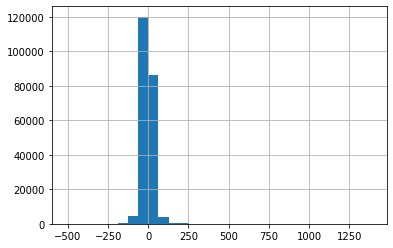

In [ ]:
model_df.net_bikes_percentage.hist(bins=30)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


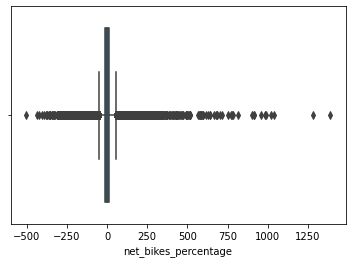

In [ ]:
sns.boxplot(model_df.net_bikes_percentage)

In [19]:
#******Try making the result binary - there were/weren't bikes left at EOD
model_df['EOD_availability'] = np.where(model_df['net_bikes_percentage'] < 0, 0, 1)

In [20]:
y = model_df['EOD_availability']
X = model_df.drop(['EOD_availability', 'net_bikes_percentage', 'start_date'], axis=1)

In [21]:
X_onehot = pd.get_dummies(X)
sc_X = StandardScaler()
sc_X = sc_X.fit_transform(X_onehot)

In [22]:
pca = PCA(.95)
trns_X = pca.fit_transform(sc_X)

In [23]:
trns_X.shape

(216869, 307)

In [24]:
#split data 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(trns_X, y, test_size = .2, random_state = 42)

In [30]:
#Now that response variable is binary, we can do:
#Dec Tree
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.5659842301839811

In [25]:
#Random Forest
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
accuracy_score(y_test, y_pred)

0.5742841333517775

In [31]:
#Gradient Boosting
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
accuracy_score(y_test, y_pred)

0.6032646285793333

In [32]:
#AdaBoost
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)
y_pred = abc.predict(X_test)
accuracy_score(y_test, y_pred)

0.6000599437451007

In [ ]:
error_rate = []

for i in [5, 10, 15, 20, 30]:
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(X_train,y_train)
  y_pred = knn.predict(X_test)
  error_rate.append(np.mean(y_pred != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,30),error_rate,color='blue', linestyle='dashed',marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

In [33]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
accuracy_score(y_test, y_pred)

0.5649697975745839

In [34]:
#We will choose Random Forest as best model at a base level (factoring in runtime), so we can work to tune its parameters
param_grid = {'n_estimators': [5,10,100],
              'max_depth': [2, 5, 9],
              'min_samples_split': [5, 10, 15],
              'min_samples_leaf': [1, 2, 5, 10]}

rfc = RandomForestClassifier()
rf_cv = RandomizedSearchCV(rfc, param_grid, cv=3)
rf_cv.fit(X_train, y_train)
print("Tuned RF Parameters: {}".format(rf_cv.best_params_))
print("Best score is {}".format(rf_cv.best_score_))

Tuned RF Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 9}
Best score is 0.602207555091632


In [35]:
#adjust Random Forest
rfc = RandomForestClassifier(n_estimators=100, max_depth=9, min_samples_split=5, min_samples_leaf=1)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
accuracy_score(y_test, y_pred)

0.6015354820860424

Text(0.5, 0, 'Random Forest Feature Importance')

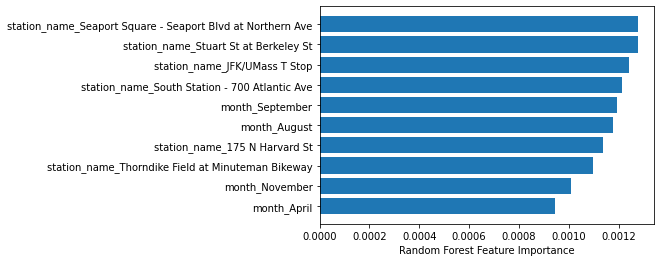

In [36]:
sorted = rfc.feature_importances_.argsort()
plt.barh(X_onehot.columns[sorted][:10], rfc.feature_importances_[sorted][:10])
plt.xlabel("Random Forest Feature Importance")

[[ 3687 15134]
 [ 2149 22404]]


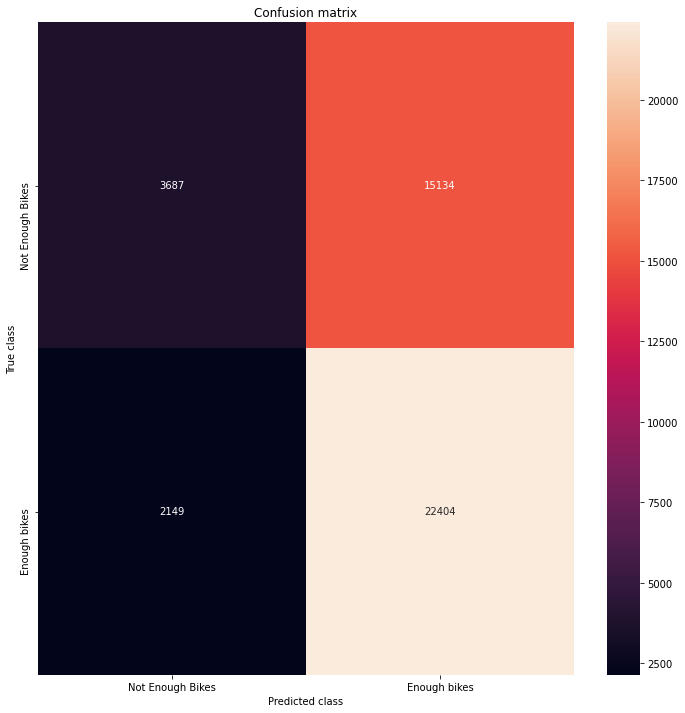

In [37]:
#confusion matrix
print(confusion_matrix(y_test, y_pred))
LABELS = ['Not Enough Bikes', 'Enough bikes']
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.20      0.30     18821
           1       0.60      0.91      0.72     24553

    accuracy                           0.60     43374
   macro avg       0.61      0.55      0.51     43374
weighted avg       0.61      0.60      0.54     43374

